# ASL Translator

### Plan for classification

    1. Train original images, output classification accuracy with original images
    2. Train preprocessed images, output classification accuracy with preprocessed images
    3. Compare accuracy between original images model and preprocessed images model

### Image Processing Pipeline

- RGB image
    - Convert to grayscale
        - Subtract mean-value
            - Binary image using canny edge detector
                - ....

In [41]:
import os
import glob
import imageio
import scipy.io
from skimage import feature
from skimage import exposure
from skimage.color import rgb2gray
from skimage.filters import gaussian
from skimage.filters.rank import median
from skimage.morphology import disk, ball
import numpy as np
import matplotlib.pyplot as plt
%matplotlib notebook

In [85]:
framesdir = "../image-classification-tensorflow-master/dataset/V/"
fnames = glob.glob(framesdir + "*.jpg")
fnames = [os.path.basename(name) for name in fnames]

num_different_images = 3

random_indeces = np.random.choice(len(fnames), num_different_images, replace=False)
chosen_fnames = np.take(fnames, random_indeces)

sigma1 = 0.1
sigma2 = 1.0

fig, ax = plt.subplots(num_different_images,5,figsize=(7,7))
fig.suptitle("Segmentation progression", fontsize=14)

for i in range(len(chosen_fnames)):
    
    # original image
    original_image = imageio.imread(framesdir + chosen_fnames[i])
    
    # grayscale iamge
    gray_img = rgb2gray(original_image)
    
    # perform canny edge detector on grayscale img using various sigma values
    img_edges_sigma1 = feature.canny(gray_img, sigma=sigma1)
    img_edges_sigma2 = feature.canny(gray_img, sigma=sigma2)
    
    # perform canny edge detector on the different rgb channels of smooth img
    edges_r = feature.canny(original_image[:,:,0], sigma=1)
    edges_g = feature.canny(original_image[:,:,1], sigma=1)
    edges_b = feature.canny(original_image[:,:,2], sigma=1)
    stacked = np.stack((edges_r,edges_g,edges_b), axis=-1)   
    summed = np.sum(stacked, axis=2)
    img_edges_rgb = np.where(summed >= 1, 1, 0)
    
    # display results
    ax[i][0].imshow(original_image)
    ax[i][0].set_title("Original")
    ax[i][1].imshow(img_edges_sigma1, cmap='gray')
    ax[i][1].set_title("Sig = {}".format(sigma1))
    ax[i][2].imshow(img_edges_sigma2, cmap='gray')
    ax[i][2].set_title("Sig = {}".format(sigma2))
    ax[i][3].imshow(img_edges_rgb, cmap='gray')
    ax[i][3].set_title("Canny on R, G, B")

for j in range(5):
    for i in range(len(chosen_fnames)):
        ax[i][j].axis("off")
        
plt.tight_layout()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


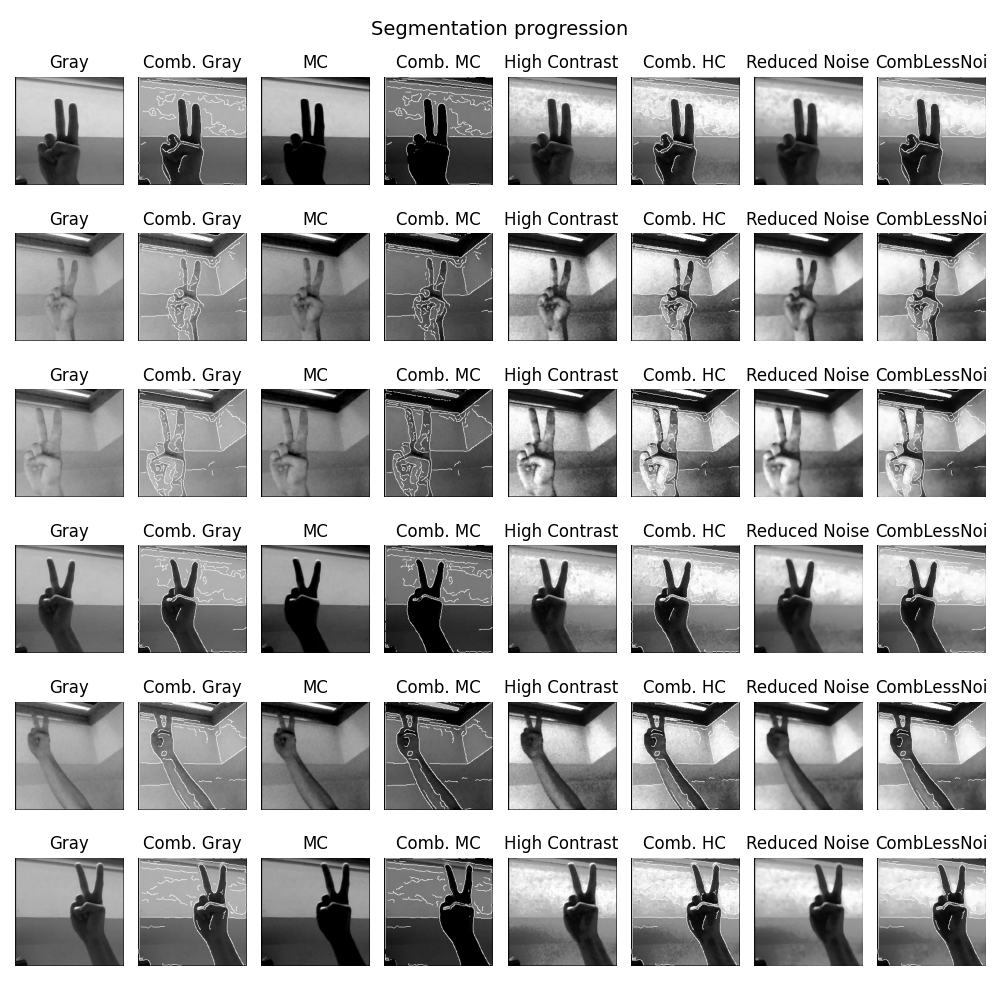

In [87]:
framesdir = "../image-classification-tensorflow-master/dataset/V/"
fnames = glob.glob(framesdir + "*.jpg")
fnames = [os.path.basename(name) for name in fnames]

num_different_images = 6

random_indeces = np.random.choice(len(fnames), num_different_images, replace=False)
chosen_fnames = np.take(fnames, random_indeces)

sigma1 = 0.1
sigma2 = 0.25
sigma3 = 0.5
sigma4 = 1
sigma5 = 3

fig, axes = plt.subplots(nrows=num_different_images,ncols=8,figsize=(10,10))
fig.suptitle("Segmentation progression", fontsize=14)
ax = axes.ravel()
x = 0

for i in range(len(chosen_fnames)):
    
    # original image
    original_image = imageio.imread(framesdir + chosen_fnames[i])
    
    # grayscale image
    gray_img = rgb2gray(original_image)
    
    # mean center the gray image (actually subtract 1/2 of the mean)
    mean_centered_gray_img = gray_img - np.mean(gray_img)*0.5    
    mean_centered_gray_img = np.where(mean_centered_gray_img < 0, 0, mean_centered_gray_img)
    
    # enhance contrast of the gray image
    high_contrast = exposure.equalize_hist(gray_img) * 255
    
    # reduce noise from enhanced image
    noiseless_img = median(high_contrast / 255, disk(3))
    
    # perform canny edge detector on reduced noise image
    edges_img = feature.canny(noiseless_img, sigma=1)
    
    ######## COMBINED IMAGES WITH EDGES_IMG ########
    
    # overlay edges on gray image
    combined_gray = gray_img * edges_img
    combined_gray = np.where(combined_gray == 0, gray_img, 1)
    
    # overlay edges on mean image
    combined_mean = mean_centered_gray_img * edges_img
    combined_mean = np.where(combined_mean == 0, mean_centered_gray_img, 1)
    
    # overlay edges on enhanced contrast image
    combined_hc = high_contrast / 255 * edges_img
    combined_hc = np.where(combined_hc == 0, high_contrast / 255, 1)
    
    # overlay edges on reduced noise image
    combined_noiseless = noiseless_img * edges_img
    combined_noiseless = np.where(combined_noiseless == 0, noiseless_img / 255.0, 1)
    
#     ax[x].imshow(edges_img, cmap='gray')
#     ax[x].set_title("Edges")
#     x += 1
    
    ax[x].imshow(gray_img, cmap='gray')
    ax[x].set_title("Gray")
    x += 1
    
    ax[x].imshow(combined_gray, cmap='gray')
    ax[x].set_title("Comb. Gray")
    x += 1
    
    ax[x].imshow(mean_centered_gray_img, cmap='gray')
    ax[x].set_title("MC")
    x += 1
    
    ax[x].imshow(combined_mean, cmap='gray')
    ax[x].set_title("Comb. MC")
    x += 1
    
    ax[x].imshow(high_contrast, cmap='gray')
    ax[x].set_title("High Contrast")
    x += 1
    
    ax[x].imshow(combined_hc, cmap='gray')
    ax[x].set_title("Comb. HC")
    x += 1
    
    ax[x].imshow(noiseless_img, vmin=0, vmax=255, cmap='gray')
    ax[x].set_title("Reduced Noise")
    x += 1
    
    ax[x].imshow(combined_noiseless, cmap='gray')
    ax[x].set_title("CombLessNoi")
    x += 1
    
for j in range(x):
    ax[j].axis("off")
        
plt.tight_layout()